## Imports

In [7]:
import os
import sys

import numpy as np
import pandas as pd

%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mpld3
import mplcursors

from sklearn.metrics import confusion_matrix, accuracy_score

from wordcloud import WordCloud

## Read data

In [10]:
# PREDICTION_FILE = 'CIL-Models/roberta-base/20210709-102233/pred_train_sub.csv'
# DATA_FILE = 'CIL-Models/sub_data.txt'
PREDICTION_FILE = '../../trainings/roberta-base/20210709-102233/pred_train_sub.csv'
DATA_FILE = '../../data/sub_data.txt'

In [11]:
raw_predictions_df = pd.read_csv(PREDICTION_FILE, names=['id', 'prediction', 'score'], dtype = {'id': int, 'prediction': int, 'score': float}, delimiter=',', header=None, skiprows=1, index_col='id')
raw_predictions_df.head()
raw_predictions_df.count

<bound method DataFrame.count of         prediction     score
id                          
1                1  0.998467
2                1  0.527401
3               -1  0.999848
4                1  0.865255
5               -1  0.960757
...            ...       ...
181321          -1  0.896623
1038            -1  0.500000
32013           -1  0.500000
162379           1  0.500000
175795           1  0.500000

[181321 rows x 2 columns]>

In [12]:
data_df = pd.read_csv(DATA_FILE, delimiter='\u0001', names=['id', 'label', 'text'], dtype = {'id': int, 'label': int, 'text': str}, header=None, index_col='id')
data_df.head()
data_df.count

<bound method DataFrame.count of         label                                               text
id                                                              
1           1  graduation speech : i'd like to thank google ,...
2          -1  <user> lol , mines was pretty cool . filled wi...
3          -1  iluv iep 313org ergonomic and comfort flat-wir...
4          -1                    <user> yes ! i am plz follow me
5           1  goes to her <user> aaw , come here <user> swit...
...       ...                                                ...
181317     -1  14x28 custom picture frame / poster frame 1.25...
181318     -1              oh no theory food tomorrow lifes over
181319      1  everyone is posting #throwbackthursday picture...
181320     -1  <user> quit we blondes need too stick together...
181321     -1           #pukpuk rt <user> saint of my life * sid

[178968 rows x 2 columns]>

In [30]:
with open(DATA_FILE, 'r') as fp:
    data_t = fp.readlines()
with open(PREDICTION_FILE, 'r') as fp:
    data_p = fp.readlines()[1:]

In [38]:
i = 0
for t in data_t:
    items = t.split('\u0001')
    assert len(items) == 3  # Check the effectiveness of delimiter and the number of columns
    idx = int(items[0])
    assert idx == i + 1     # Check if the ids is an arithmetic progression with a common difference of 1
    i += 1
    assert items[1] in ['1', '-1']  # Check if there is any problem in labels
    assert len(items[2].strip()) > 0  # Check the length of text



In [27]:
assert len(data_t) == len(data_p)

In [40]:
predictions_df = raw_predictions_df.join(data_df, on='id')
predictions_df.head()
predictions_df.dtypes

prediction      int32
score         float64
label         float64
text           object
dtype: object

## Helper functions

In [43]:
def visualize_word_frequencies(words, title=''):
    fig = plt.figure(figsize=(8,4))
    plot = fig.add_subplot()
    wordcloud = WordCloud()
    frequency_dist = nltk.FreqDist(words)
    sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:50] 
    wordcloud.generate_from_frequencies(frequency_dist)
    
    plt.imshow(wordcloud)
    plt.title("Wordfrequencies - " + title)
    plt.axis("off")
    plt.show()

## Analysis

#### Print accuracy

In [57]:
print('Accuracy:')
print(accuracy_score(predictions_df['label'].to_numpy(), predictions_df['prediction'].to_numpy()))
print('Confusion matrix:')
confusion_matrix(predictions_df['label'].to_numpy(), predictions_df['prediction'].to_numpy(), normalize='all')

Accuracy:


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

#### Text preprocessing

In [56]:
tp_df = predictions_df.query('1 == prediction & label == 1')
fp_df = predictions_df.query('1 == prediction & label == -1')
tn_df = predictions_df.query('-1 == prediction & label == -1')
fn_df = predictions_df.query('-1 == prediction & label == 1')

In [29]:
tp_text = tp_df['text'].tolist()
fp_text = fp_df['text'].tolist()
tn_text = tn_df['text'].tolist()
fn_text = fn_df['text'].tolist()

In [34]:
tp_processed = []
for txt in tp_text:
    tp_processed.extend([simple_preprocess(txt)])

In [35]:
fp_processed = []
for txt in fp_text:
    fp_processed.extend([simple_preprocess(txt)])

In [36]:
tn_processed = []
for txt in tn_text:
    tn_processed.extend([simple_preprocess(txt)])

In [37]:
fn_processed = []
for txt in fn_text:
    fn_processed.extend([simple_preprocess(txt)])

### Plot tweet lengths

In [47]:
lengths_tp = [len(tokens) for tokens in tp_processed]
lengths_fp = [len(tokens) for tokens in fp_processed]
lengths_tn = [len(tokens) for tokens in tn_processed]
lengths_fn = [len(tokens) for tokens in fn_processed]

<IPython.core.display.Javascript object>


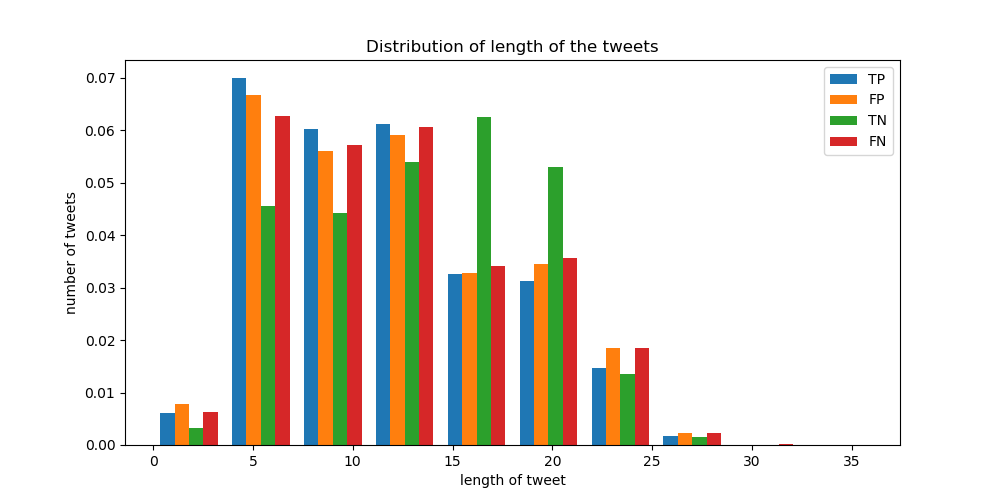

C:\Users\m_lev\Anaconda3\envs\ml4hc\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


In [70]:
x, y = np.unique(lengths, return_counts=True)
fig = plt.figure(figsize=(10,5))
plot = fig.add_subplot()

names = ['TP', 'FP', 'TN', 'FN']
plot.hist([lengths_tp, lengths_fp, lengths_tn, lengths_fn], label=names, normed=True)

plt.legend()
plt.title("Distribution of length of the tweets")
plt.xlabel("length of tweet")
plt.ylabel("number of tweets")

plt.show()

#### Word frequencies

<IPython.core.display.Javascript object>


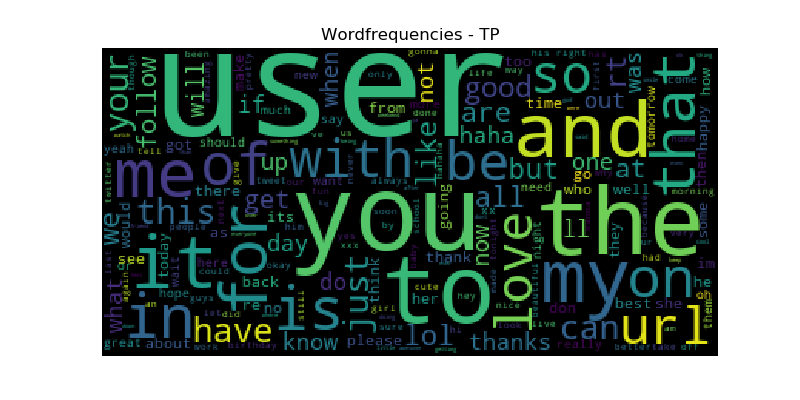

In [85]:
tp_flat_list = [item for sublist in tp_processed for item in sublist]
visualize_word_frequencies(tp_flat_list, 'TP')

<IPython.core.display.Javascript object>


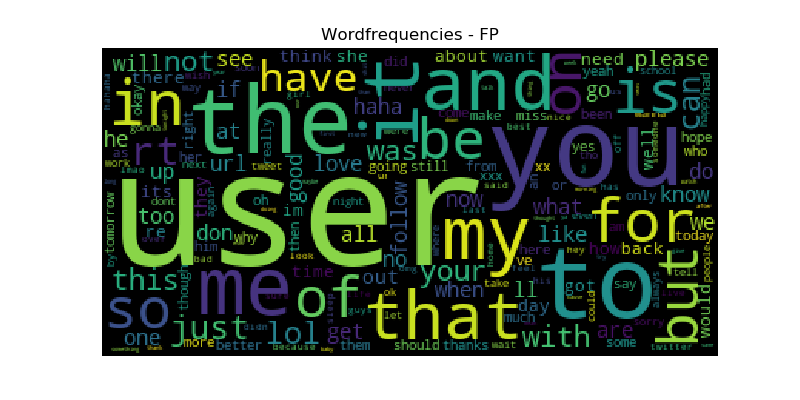

In [90]:
fp_flat_list = [item for sublist in fp_processed for item in sublist]
visualize_word_frequencies(fp_flat_list, 'FP')

<IPython.core.display.Javascript object>


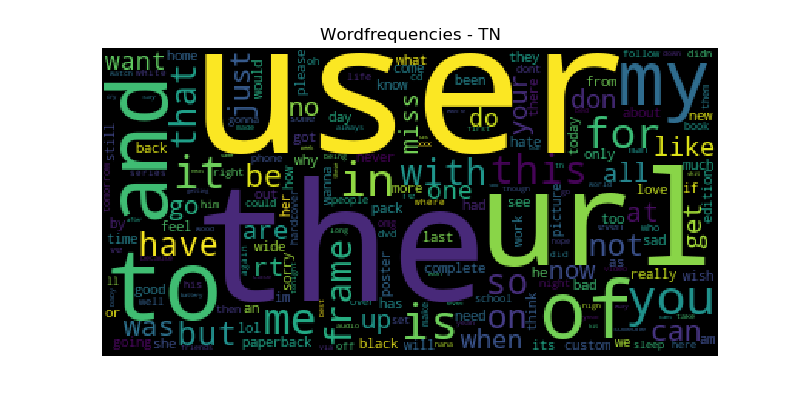

In [91]:
tn_flat_list = [item for sublist in tn_processed for item in sublist]
visualize_word_frequencies(tn_flat_list, 'TN')

<IPython.core.display.Javascript object>


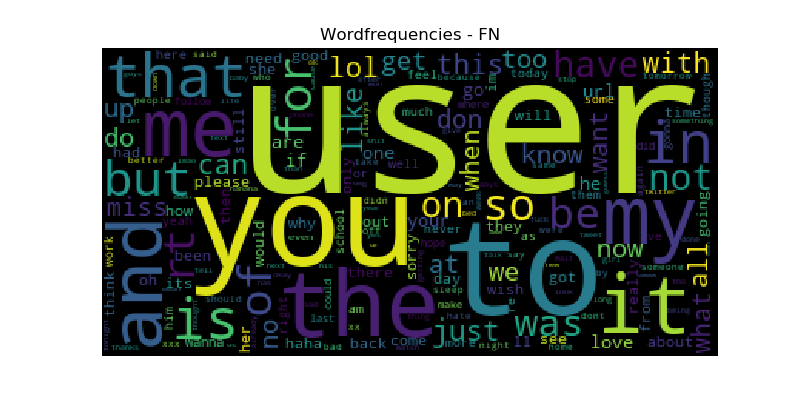

In [89]:
fn_flat_list = [item for sublist in fn_processed for item in sublist]
visualize_word_frequencies(fn_flat_list, 'FN')